In [211]:
import pandas as pd
import numpy as np
from pathlib import Path
from create_reference_from_tsv_and_pepxml import ReferenceWriter
from create_PSM_df import PSM_FDR
from collections import defaultdict
from ReadAccTaxon import ReadAccTaxon
# load taxon graph
import sys  
sys.path.insert(0, '/home/jules/tax2proteome_projects/tax2proteome/')
from TaxonGraph import TaxonGraph
taxon_graph = TaxonGraph()
taxon_graph.create_graph("/home/jules/Documents/Metaproteomics/databases/databases_tax2proteome/taxdump.tar.gz")

path_to_kleiner_results_bachelor = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/"
path_to_tanca_results_bachelor = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/9MM_FASP/x_tandem_tsv"

uniprot_nr_reduced_tsv = {
    'subspecies': path_to_kleiner_results_bachelor + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_subspecies.t.xml_new_reduced.tsv",
    'species': path_to_kleiner_results_bachelor + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_new_reduced.tsv",
    'genus': path_to_kleiner_results_bachelor + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_genus_nr.t.xml_new_reduced.tsv",
    'family': path_to_kleiner_results_bachelor + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_family_nr.t.xml_new_reduced.tsv",
}

tanca_uniprot_tsv = {
    'species': path_to_tanca_results_bachelor + "/9MM_FASP_uniprot_Tanca_species_nr.t.xml_new_reduced.tsv",
    'genus': path_to_tanca_results_bachelor + "/9MM_FASP_uniprot_Tanca_genus.t.xml_new_reduced.tsv",
    'family': path_to_tanca_results_bachelor + "/9MM_FASP_uniprot_Tanca_family_nr.t.xml_new_reduced.tsv",
    'order': path_to_tanca_results_bachelor + "/9MM_FASP_uniprot_Tanca_order_nr.t.xml_new_reduced.tsv"
}
#species_name, species_taxon, %protein
Kleiner_species_taxa = [
    ("Escherichia coli", [562], 5.788), 
    ("Salmonella enterica", [28901], 33.773), 
    ("Bacillus subtilis", [1423], 0.788), 
    ("Staphylococcus aureus", [1280], 2.605), 
    ("Desulfovibrio vulgaris", [881], 0.946), 
    ("Thermus thermophilus", [274], 1.68),  
    ("Chlamydomonas reinhardtii", [3055], 3.996), 
    ("Paracoccus denitrificans", [266], 0.922), 
    ("Nitrososphaera viennensis", [1034015], 0.819), 
    ("Stenotrophomonas maltophilia", [40324], 8.021), 
    ("Altermonas macleodii", [28108], 0.954), 
    ("Chromobacterium violaceum", [536], 1.259), 
    ("Paraburkholderia xenovorans", [36873], 0.433), 
    ("Cupriavidus metallidurans", [119219], 15.519),
    ("Nitrosomonas ureae", [44577], 0.543), 
    ("Nitrosomonas europaea", [915], 0.082), 
    ("Nitrosospira multiformis", [1231], 0.209),
    ("Agrobacterium fabrum", [1176649], 5.647), 
    ("Rhizobium leguminosarum", [384], 3.172), 
    ("Pseudomonas fluorescens", [294], 6.696), 
    ("Pseudomonas furukawaii", [1149133], 1.165), 
    ("Pseudomonas sp. ATCC 13867", [1294143], 2.871) 
]
#genus_name species_taxa, genus_taxa, %protein
Kleiner_genus_groups = [ 
    ("Nitrosomonas", [44577, 915],  [914], 0.644), 
    ("Pseudomonas", [294, 1149133, 1294143], [286], 10.733),
    ("viruses", [10754, 101570, 1985310, 329852, 1977402], [186794, 196894, 1198140, 11990, 10861], 0.513)
]

#family_name species_taxa, family_taxa, %protein
Kleiner_family_groups = [
    ("Enterobacteriaceae", [28901, 562],  [543], 39.561), 
    ("Burkholderiaceae", [36873, 119219], [119060], 15.519),
    ("Nitrosomonadaceae", [44577, 915, 1231],  [206379], 0.834), 
    ("Rhizobiaceae", [1176649, 384],  [82115], 8.819), 
    ("Pseudomonadaceae", [294, 1149133, 1294143], [135621], 10.733),
    ("viruses", [10754, 101570, 1985310, 329852, 1977402], [10744, 10699, 10662, 11989, 10860], 0.513)
]

Tanca_species_taxa = [
    ("Pasteurella multocida", [747], 11.1), ("Brevibacillus laterosporus", [1465], 11.1), 
    ("Lactobacillus acidophilus", [1579], 11.1), ("Lactobacillus casei", [1582], 11.1),
    ("Pediococcus pentosaceus", [1255], 11.1), ("Enterococcus faecalis", [1351], 11.1), 
    ("Rhodotorula glutinis", [5535], 11.1), ("Saccharomyces cerevisiae", [4932], 11.1),
    ("Escherichia coli", [562], 11.1)
]

Tanca_genus_groups = [("Lactobacillus", [1579,1582], [1578], 22.2)]
Tanca_family_groups = [("Lactobacillaceae", [1579,1582,1255], [33958], 33.3)]

In [ ]:
#plot %psm, %DB, %protein

import seaborn as sns
def get_sized_down_to_100_percentage(percent, sum_percent):
    return percent/sum_percent*100

def get_percentage_psm_per_taxon(df_in_fdr, taxID_to_spectra_dict, taxon_str, level):
    final_taxa_set= set()
    psm_percentage = {}
    for taxon in taxon_str.split(', '):
        taxon = int(taxon) if taxon not in ['viruses', 'CRAP','DECOY'] else taxon
        if type(taxon)==int:
            taxon_of_level = taxon_graph.find_level_up(taxon, level) if level != 'subspecies' else taxon
            final_taxa_set=final_taxa_set.union(taxID_to_spectra_dict[taxon_of_level])
        elif taxon == 'viruses':
            taxon_of_level = {10754, 101570, 1985310, 329852, 1977402} if level == 'species' else {10744, 10699, 10662, 11989, 10860}
            for tax in taxon_of_level:
                final_taxa_set=final_taxa_set.union(taxID_to_spectra_dict[tax])
    psm_percentage = len(final_taxa_set)/len(set(df_in_fdr.Title))*100
    return psm_percentage

def count_row_by_row(df_in_fdr, level):
    taxID_to_spectra_dict = defaultdict(set)
    for spectrum, taxID_set in zip(df_in_fdr['Title'], df_in_fdr[f"taxID_{level}"]):
        for taxID in taxID_set:
            taxID_to_spectra_dict[taxID].add(spectrum)
    return taxID_to_spectra_dict
                                                   
def get_perc_per_taxa_df(df_in_fdr, path_to_bachelor_result, level):  
    taxID_to_spectra_dict = count_row_by_row(df_in_fdr, level)
    result_df = pd.read_csv(path_to_bachelor_result, sep='\t')
   # taxon_to_db_percentage = {t:db for t, db in zip(list(df['taxon(s)']), list(df['% database']))}
    result_df['% PSM_not_adapted'] = result_df.apply(lambda row: get_percentage_psm_per_taxon(df_in_fdr, taxID_to_spectra_dict, row['taxon(s)'], level), axis=1)
    sum_percent = result_df[~result_df['% PSM_not_adapted'].isin(['CRAP','DECOY', 'virus'])]['% PSM_not_adapted'].sum()
    result_df['% PSM'] = result_df.apply(lambda row: get_sized_down_to_100_percentage(row['% PSM_not_adapted'], sum_percent), axis=1)
    # print(df)
    result_df = result_df[["taxon(s)", "% PSM", "% protein", "% database"]]
    return result_df
                                                   

def create_psms_per_taxID_plot(df_in_fdr, path_to_bachelor_result, level, fdr, outputpath):
    # take old df and calculate '% PSM' new for all taxids
    sns.set_style("white")
    kleiner_palette_strain = [ 'red', 'lightcoral', 'grey', 'darkgrey', 'chocolate', 'mediumpurple','darkorchid','rebeccapurple',   'chocolate', 'limegreen', 'forestgreen', 'grey', 'sienna', 'chocolate', 'firebrick',  'dodgerblue', 'royalblue', 'gold', 'darkorange', 'orange', 'yellow', 'khaki', 'lemonchiffon', 'lightcoral', 'chocolate']
    kleiner_palette_species = [ 'red', 'lightcoral', 'grey', 'darkgrey', 'chocolate', 'mediumpurple','darkorchid','rebeccapurple', 'chocolate', 'limegreen', 'forestgreen', 'grey', 'sienna', 'firebrick',  'dodgerblue', 'royalblue', 'gold', 'darkorange', 'orange', 'yellow', 'lemonchiffon', 'lightcoral', 'chocolate']
    kleiner_palette_genus = [ 'red', 'lightcoral', 'grey', 'darkgrey', 'chocolate', 'rebeccapurple', 'chocolate', 'limegreen', 'forestgreen', 'grey', 'sienna', 'firebrick',  'dodgerblue', 'royalblue', 'gold', 'darkorange', 'orange', 'yellow', 'lemonchiffon', 'lightcoral', 'chocolate']
    kleiner_palette_family = [ 'red', 'lightcoral', 'grey','darkgrey', 'chocolate', 'rebeccapurple', 'chocolate',  'forestgreen', 'grey', 'firebrick',  'royalblue', 'gold', 'darkorange',  'lemonchiffon', 'lightcoral', 'chocolate']
    kleiner_palette_order = [ 'red', 'lightcoral', 'grey', 'darkgrey', 'chocolate', 'rebeccapurple', 'chocolate',  'forestgreen', 'grey', 'firebrick',  'royalblue', 'darkorange', 'lemonchiffon', 'lightcoral', 'chocolate']
    if level == 'subspecies':
        palette=kleiner_palette_strain
    elif level == 'species':
        palette=kleiner_palette_species
    elif level == 'genus':
        palette=kleiner_palette_genus
    elif level == 'family':
        palette=kleiner_palette_family
    elif level == 'order':
        palette=kleiner_palette_order
    db = 'Uniprot'

    result_df = get_perc_per_taxa_df(df_in_fdr, path_to_bachelor_result, level)
    print(result_df)       
    sns.set_palette(sns.color_palette(palette))
    ax = result_df.set_index("taxon(s)").reindex(result_df.set_index("taxon(s)").sum().index, axis=1).T.plot(kind='bar', stacked=True, width=0.6,
          figsize=(18,9), fontsize=30)
    # ,title=("Species:Kleiner\ndatabase: %s   level: %s" %(db, level))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower center', bbox_to_anchor=(1.3, 0.1))
    ax.get_legend().set_visible(False)
    #ax.set_xticklabels("")
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    fig = ax.get_figure()
    #plt.tight_layout()
    #plt.ylim([0,100])
    #fig = plt.gcf()
    fig.savefig(Path(outputpath), format='svg')

In [218]:
def get_hit_rows2(decoy_column):
    return [True if d_set in  [{True, False}, {False}] else False for d_set in decoy_column]

def get_psm_and_df_in_fdr(file, fdr, remove_one_charged_spectra=False, columns=None):
    cs = ['Protein', 'Hyperscore', 'decoy', 'taxID']
    if columns:
        cs = cs + columns
    reduced_df = ReferenceWriter.read_csv_with_generic_function(file, cs, remove_one_charged_spectra)
    fdr_pos_result, number_psm_result, number_decoy_result, double_spectra_result, score_last_item_result = PSM_FDR.determine_FDR_position(reduced_df, fdr)
    return number_psm_result, reduced_df[0:fdr_pos_result]

def get_df_in_fdr_without_decoy(file, fdr, remove_one_charged_spectra=True, columns=None):
    df = get_psm_and_df_in_fdr(file, fdr, remove_one_charged_spectra, columns)[1]
    df = df[get_hit_rows2(df.decoy)]
    return df

def get_acc_rows(column, acc):
    return [True if acc in acc_list else False for acc_list in column ]

def get_taxa_rows(column, taxID):
    if type(taxID)==int:
        return [True if taxID in t_set else False for t_set in column]
    elif type(taxID)==list:
        return [True if len(set(taxID).intersection(set(taxa_set)))>0 else False for taxa_set in column]

def get_exclusive_rows(column, taxid):
    if type(taxid)==int:
        return [True if {taxid} == t_set else False for t_set in column]
    elif type(taxid)==list:
        return [True if len(set(t_set).difference(taxid))==0 else False for t_set in column]

def remove_acc_row(column, acc_to_remove_set):
    return [False if len(set(accs).difference(acc_to_remove_set))==0 else True for accs in column]

def remove_empty_rows(column):
    return [False if len(accs)==0 else True for accs in column]

def add_tax_information(acc_list, acc2tax_dict, level):
    tax_list=[]
    for acc in acc_list:
        try:
            tax_list.append(taxon_graph.find_level_up(acc2tax_dict[acc], level))
        except KeyError:
            tax_list.append('CRAP')
    return tax_list

def remove_all_accs_with_less_then_x_peptides(df, level, nb_peptides, acc2tax_dict):
    acc_to_peptide_dict=defaultdict(set)
    accs_to_remove= set()
    accs_to_keep = set()
    for index, row in df.iterrows():
        for acc in row['Protein']:
            acc_to_peptide_dict[acc].add(row["Peptide"])
    for acc, pep_set in acc_to_peptide_dict.items():
        if len(pep_set)<nb_peptides:
            accs_to_remove.add(acc)
        else:
            accs_to_keep.add(acc)
    df_no_one_hits=df[remove_acc_row(df.Protein, accs_to_remove)]
    df_no_one_hits.Protein = df_no_one_hits.Protein.apply(lambda acc_list: set(acc_list).intersection(accs_to_keep))
    df_no_one_hits.Protein = df_no_one_hits.Protein.apply(lambda acc_set: sorted(list(acc_set)))
    df_no_one_hits = df_no_one_hits[remove_empty_rows(df_no_one_hits.Protein)]
    df_no_one_hits[f"taxID_{level}"] = df_no_one_hits.Protein.apply(lambda acc_list: add_tax_information(acc_list, acc2tax_dict, level))
    return df_no_one_hits

def remove_unrelated_accs_and_taxa(df, taxids, level, acc_2_taxid_dict):
    df.Protein = df.Protein.apply(lambda acc_list: [acc for acc in acc_list if \
                                                    get_taxid_of_acc(acc, level, taxon_graph, acc_2_taxid_dict) in taxids])
    df[f"taxID_{level}"] = df.Protein.apply(lambda acc_list: [get_taxid_of_acc(acc, level, taxon_graph, acc_2_taxid_dict) for acc in acc_list])
    return df

def taxon_exclusive_spectra(df, df_no_one_hits, taxon, level, acc_2_taxid_dict):
    df_identified_spectra_for_taxa = df[get_taxa_rows(df[f"taxID_{level}"], taxon)]
    if df_identified_spectra_for_taxa.empty:
        df_identified_spectra_for_taxa = pd.DataFrame(columns=["Title", "Protein", f"taxID_species"])
    df_exclusive_spectra = df_identified_spectra_for_taxa[get_exclusive_rows(df_identified_spectra_for_taxa[f"taxID_{level}"], taxon)]
    if df_exclusive_spectra.empty:
        df_exclusive_spectra = pd.DataFrame(columns=["Title", "Protein", f"taxID_{level}"])
    exclusive_spectra = set(df_exclusive_spectra.Title)
    df_identified_spectra_for_taxa = remove_unrelated_accs_and_taxa(df_identified_spectra_for_taxa, taxon, level, acc_2_taxid_dict)
    all_identified_accs = set([item for sublist in df_identified_spectra_for_taxa.Protein for item in sublist])
    all_identified_spectra = set(df_identified_spectra_for_taxa.Title)

    df_identified_spectra_no_one_hits_for_taxa = df_no_one_hits[get_taxa_rows(df_no_one_hits[f"taxID_{level}"], taxon)]
    if df_identified_spectra_no_one_hits_for_taxa.empty:
        df_identified_spectra_no_one_hits_for_taxa = pd.DataFrame(columns=["Title", "Protein", f"taxID_{level}"])
    df_exclusive_spectra_no_one_hits = df_identified_spectra_no_one_hits_for_taxa[get_exclusive_rows(df_identified_spectra_no_one_hits_for_taxa[f"taxID_{level}"], taxon)]
    if df_exclusive_spectra_no_one_hits.empty:
        df_exclusive_spectra_no_one_hits = pd.DataFrame(columns=["Title", "Protein", f"taxID_{level}"])
    exclusive_spectra_no_one_hits = set(df_exclusive_spectra_no_one_hits.Title)
    df_identified_spectra_no_one_hits_for_taxa = remove_unrelated_accs_and_taxa(df_identified_spectra_no_one_hits_for_taxa, taxon, level, acc_2_taxid_dict)
    all_identified_spectra_no_one_hits = set(df_identified_spectra_no_one_hits_for_taxa.Title)
    all_identified_accs_no_one_hits = set([item for sublist in df_identified_spectra_no_one_hits_for_taxa.Protein for item in sublist])

    return all_identified_spectra, all_identified_spectra_no_one_hits, all_identified_accs, \
            all_identified_accs_no_one_hits, exclusive_spectra, exclusive_spectra_no_one_hits


def get_acc2taxid_dict(df_in_fdr_uniprot_species, df_in_fdr_uniprot_family):
    all_accs={item for sublist in df_in_fdr_uniprot_species.Protein for item in sublist}
    all_accs=all_accs.union({item for sublist in df_in_fdr_uniprot_family.Protein for item in sublist})
    final_accs = set()
    for acc in all_accs:
        try:
            final_accs.add(acc.split('|')[1])
        except:
            final_accs.add(acc)
    acc2tax_reader=ReadAccTaxon("/home/jules/Documents/Metaproteomics/databases/databases_tax2proteome/", "uniprot")
    acc_to_taxid_dict = acc2tax_reader.read_acc2tax(final_accs)
    acc_to_taxid_dict = {key: int(taxid) for key, taxid in acc_to_taxid_dict.items()}
    return acc_to_taxid_dict

def get_taxids_of_accs(acc_list, level, taxon_graph, acc_to_taxid_dict):
    taxid_list = []
    for acc in acc_list:
        taxid_list.append(get_taxid_of_acc(acc, level, taxon_graph, acc_to_taxid_dict))
    return taxid_list

def get_taxid_of_acc(acc, level, taxon_graph, acc_to_taxid_dict):
    try:
        taxid = taxon_graph.find_level_up(acc_to_taxid_dict[acc], level)
    except KeyError:
        taxid = "CRAP"
    return taxid

def sort_taxid_and_acc_in_df(df, level, acc_to_taxid_dict):
    df.Protein = df.Protein.apply(lambda acc_set: sorted(list(acc_set)))
    df[f"taxID_{level}"] = df.Protein.apply(lambda acc_list: get_taxids_of_accs(acc_list, level, taxon_graph, acc_to_taxid_dict))
    return df

def spectra_identified_in_df(df_species, df_level, taxon_species, taxon_level, level):
    species_spectra = set(df_species[get_taxa_rows(df_species.taxID_species, taxon_species)].Title)
    level_spectra = set(df_level[get_taxa_rows(df_level[f"taxID_{level}"], taxon_level)].Title)
    new_identified_spectra = level_spectra.difference(species_spectra)
    all_species_spectra = set(df_species.Title)
    spectra_in_species_df = new_identified_spectra.intersection(all_species_spectra)
    return new_identified_spectra, spectra_in_species_df

def load_dfs(tsv_dict, level_list=None):
    fdr=0.05
    if not level_list:
        level_list = ['species', 'genus', 'family']
    result_dfs= {}
    for level in level_list:
        tsv = tsv_dict[level]
        df_in_fdr = get_df_in_fdr_without_decoy(tsv, fdr, columns=[f'taxID_{level}'])
        df_in_fdr.Protein = df_in_fdr.Protein.apply(lambda acc_set: {acc.split('|')[1] for acc in acc_set})
        result_dfs[level] = df_in_fdr    
    return result_dfs['species'], result_dfs['genus'], result_dfs['family']

def mean_deviation(spectra, all_spectra, protein):
    try:
        return abs(len(spectra)/all_spectra*100 - protein)
    except:
        return '/'

def calculate_percent(a,b, multiplikator=1):
    try:
        return len(a)/len(b)*multiplikator
    except:
        return '/'

def write_header(out):
    fields = ["name", "taxon species", "taxon genus", "taxon family", "% protein", 
              "all identified spectra - species", "all identified spectra - genus", "all identified spectra - family",
              "% more gen", "% more fam", 
              "all identified spectra more than x hits - species", "all identified spectra more than x hits - genus",
              "all identified spectra more than x hits - family", "% more gen", "% more fam", 
             "mean deviation species", "mean deviation genus", "mean deviation family",
             "exclusive spectra - species", "%", "exclusive spectra - genus", "%", "exclusive spectra - family", "%",
             "exclusive spectra more than x hits - species", "%", "exclusive spectra more than x hits - genus", "%", "exclusive spectra more than x hits - family", "%",
             "exclusive spectra: intersection species - genus", "exclusive spectra: intersection species - family", 
             "exclusive spectra more than x hits: intersection species - genus", "exclusive spectra more than x hits: intersection species - family",
              "all_identified_accs_species", "all_identified_accs_genus", "all_identified_accs_fam",
              "all_identified_accs_spe_no_one_hits", "all_identified_accs_genus_no_one_hits",  "all_identified_accs_fam_no_one_hits", 
              "new_identified_spectra in gen no one hits", "new_identified_spectra in gen already in species_df no one hit", 
             "new_identified_spectra in fam no one hits", "new_identified_spectra in fam already in species_df no one hit"]
    out.write("\t".join(fields))    
    out.write(f"\n")


    
def write_results(out, name, taxon_species, taxon_genus, taxon_family, protein, nb_all_spectra_spe, nb_all_spectra_gen, nb_all_spectra_fam, 
              all_identified_spectra_spe, all_identified_spectra_gen, all_identified_spectra_fam,
              all_identified_spectra_no_one_hits_spe, all_identified_spectra_no_one_hits_gen, all_identified_spectra_no_one_hits_fam,  
              all_identified_accs_spe, all_identified_accs_spe_no_one_hits,
              all_identified_accs_gen, all_identified_accs_gen_no_one_hits,
              all_identified_accs_fam, all_identified_accs_fam_no_one_hits,
              exclusive_spectra_spe, exclusive_spectra_gen, exclusive_spectra_fam,
              exclusive_spectra_no_one_hits_spe, exclusive_spectra_no_one_hits_gen, exclusive_spectra_no_one_hits_fam,
              new_identified_spectra_no_one_hits_gen, spectra_in_species_df_no_one_hits_gen,
              new_identified_spectra_no_one_hits_fam, spectra_in_species_df_no_one_hits_fam):
    fields = [name, taxon_species, taxon_genus, taxon_family, protein,
              len(all_identified_spectra_spe), len(all_identified_spectra_gen), len(all_identified_spectra_fam),
              calculate_percent(all_identified_spectra_gen, all_identified_spectra_spe),
              calculate_percent(all_identified_spectra_fam, all_identified_spectra_spe),
              len(all_identified_spectra_no_one_hits_spe), len(all_identified_spectra_no_one_hits_gen), len(all_identified_spectra_no_one_hits_fam),
              calculate_percent(all_identified_spectra_no_one_hits_gen, all_identified_spectra_no_one_hits_spe), 
              calculate_percent(all_identified_spectra_no_one_hits_fam, all_identified_spectra_no_one_hits_spe), 
              mean_deviation(all_identified_spectra_no_one_hits_spe, nb_all_spectra_spe, protein), mean_deviation(all_identified_spectra_no_one_hits_gen, nb_all_spectra_gen, protein), mean_deviation(all_identified_spectra_no_one_hits_fam, nb_all_spectra_fam, protein),
              
              len(exclusive_spectra_spe), calculate_percent(exclusive_spectra_spe, all_identified_spectra_spe, 100),
              len(exclusive_spectra_gen), calculate_percent(exclusive_spectra_gen, all_identified_spectra_gen, 100), 
              len(exclusive_spectra_fam), calculate_percent(exclusive_spectra_fam, all_identified_spectra_fam, 100),
              len(exclusive_spectra_no_one_hits_spe), calculate_percent(exclusive_spectra_no_one_hits_spe, all_identified_spectra_spe, 100),
              len(exclusive_spectra_no_one_hits_fam), calculate_percent(exclusive_spectra_no_one_hits_gen, all_identified_spectra_gen, 100),
              len(exclusive_spectra_no_one_hits_fam), calculate_percent(exclusive_spectra_no_one_hits_fam, all_identified_spectra_fam, 100),
              len(exclusive_spectra_spe.intersection(exclusive_spectra_gen)), len(exclusive_spectra_spe.intersection(exclusive_spectra_fam)),
              len(exclusive_spectra_no_one_hits_spe.intersection(exclusive_spectra_no_one_hits_gen)),
              len(exclusive_spectra_no_one_hits_spe.intersection(exclusive_spectra_no_one_hits_fam)),
             
              len(all_identified_accs_spe),len(all_identified_accs_gen),len(all_identified_accs_fam),
              len(all_identified_accs_spe_no_one_hits), len(all_identified_accs_gen_no_one_hits), len(all_identified_accs_fam_no_one_hits),
             
              len(new_identified_spectra_no_one_hits_gen), len(spectra_in_species_df_no_one_hits_gen),
              len(new_identified_spectra_no_one_hits_fam), len(spectra_in_species_df_no_one_hits_fam)]

    out.write("\t".join(["%.3f" %round(field, 3) if type(field)==float else str(field) for field in fields  ]))    
    out.write(f"\n")

In [219]:
def determine_and_write_analysis_results(out, name, taxon_species, taxon_genus, taxon_family, protein, acc_to_taxid_dict,\
                                         nb_all_spectra_spe, nb_all_spectra_gen, nb_all_spectra_fam, \
                                         df_species, df_species_no_one_hits, df_genus, df_genus_no_one_hits, \
                                         df_family, df_family_no_one_hits):
    all_identified_spectra_spe, all_identified_spectra_no_one_hits_spe, all_identified_accs_spe, all_identified_accs_spe_no_one_hits, exclusive_spectra_spe, exclusive_spectra_no_one_hits_spe = \
                   taxon_exclusive_spectra(df_species, df_species_no_one_hits, taxon_species, 'species', acc_to_taxid_dict)

    if taxon_genus:
        all_identified_spectra_gen, all_identified_spectra_no_one_hits_gen, all_identified_accs_gen, all_identified_accs_gen_no_one_hits, exclusive_spectra_gen, exclusive_spectra_no_one_hits_gen = \
            taxon_exclusive_spectra(df_genus, df_genus_no_one_hits, taxon_genus, 'genus', acc_to_taxid_dict)
     #   new_identified_spectra_gen, spectra_in_species_df_gen = spectra_identified_in_df(df_species, df_genus, taxon_species, taxon_genus, 'genus')
        new_identified_spectra_no_one_hits_gen, spectra_in_species_df_no_one_hits_gen = spectra_identified_in_df(df_species_no_one_hits,
                                                                                 df_genus_no_one_hits, taxon_species, taxon_genus, 'genus')

    else:
        all_identified_spectra_gen, all_identified_spectra_no_one_hits_gen, all_identified_accs_gen, all_identified_accs_gen_no_one_hits, exclusive_spectra_gen, exclusive_spectra_no_one_hits_gen = \
            set(), set(), set(), set(), set(), set()
     #   new_identified_spectra_gen, spectra_in_species_df_gen = set(), set()
        new_identified_spectra_no_one_hits_gen, spectra_in_species_df_no_one_hits_gen = set(), set()
    
    if taxon_family:
        all_identified_spectra_fam, all_identified_spectra_no_one_hits_fam, all_identified_accs_fam, all_identified_accs_fam_no_one_hits, exclusive_spectra_fam, exclusive_spectra_no_one_hits_fam = \
            taxon_exclusive_spectra(df_family, df_family_no_one_hits, taxon_family, 'family', acc_to_taxid_dict)
       # new_identified_spectra_fam, spectra_in_species_df_fam = spectra_identified_in_df(df_species, df_family, taxon_species, taxon_family, 'family')
        new_identified_spectra_no_one_hits_fam, spectra_in_species_df_no_one_hits_fam = spectra_identified_in_df(df_species_no_one_hits,
                                                                                                                 df_family_no_one_hits, taxon_species, taxon_family, 'family')
    else:
        all_identified_spectra_fam, all_identified_spectra_no_one_hits_fam, all_identified_accs_fam, all_identified_accs_fam_no_one_hits, exclusive_spectra_fam, exclusive_spectra_no_one_hits_fam = set(), set(), set(), set(), set(), set()
       # new_identified_spectra_fam, spectra_in_species_df_fam = set(), set()
        new_identified_spectra_no_one_hits_fam, spectra_in_species_df_no_one_hits_fam = set(), set()
    
    write_results(out, name, taxon_species, taxon_genus, taxon_family, protein, 
                  nb_all_spectra_spe, nb_all_spectra_gen, nb_all_spectra_fam, 
              all_identified_spectra_spe, all_identified_spectra_gen, all_identified_spectra_fam,
              all_identified_spectra_no_one_hits_spe, all_identified_spectra_no_one_hits_gen, all_identified_spectra_no_one_hits_fam,  
              all_identified_accs_spe, all_identified_accs_spe_no_one_hits,
              all_identified_accs_gen, all_identified_accs_gen_no_one_hits,
              all_identified_accs_fam, all_identified_accs_fam_no_one_hits,
              exclusive_spectra_spe, exclusive_spectra_gen, exclusive_spectra_fam,
              exclusive_spectra_no_one_hits_spe, exclusive_spectra_no_one_hits_gen, exclusive_spectra_no_one_hits_fam,
              new_identified_spectra_no_one_hits_gen, spectra_in_species_df_no_one_hits_gen,
              new_identified_spectra_no_one_hits_fam, spectra_in_species_df_no_one_hits_fam)

def calculate_and_write_analysis_results(df_species, df_genus, df_family, acc_to_taxid_dict, single_taxa, genus_taxa, family_taxa, dataset):
    with open(f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_analysis/all_spectra_more_than_x_hits.tsv", "w") as out:
        out.write(f"mind_hits\tlevel\tnumber_spectra\n") 

    for number_hits in [1,2,3,4]:
        print(number_hits)
        df_species_no_one_hits = remove_all_accs_with_less_then_x_peptides(df_species.copy(deep=True),  
                                                                                      'species', number_hits, acc_to_taxid_dict)
        df_genus_no_one_hits = remove_all_accs_with_less_then_x_peptides(df_genus.copy(deep=True),  
                                                                                     'genus', number_hits, acc_to_taxid_dict)        
        df_family_no_one_hits = remove_all_accs_with_less_then_x_peptides(df_family.copy(deep=True),  
                                                                                     'family', number_hits, acc_to_taxid_dict)        
        nb_all_spectra_spe = len(set(df_species_no_one_hits.Title))
        nb_all_spectra_gen = len(set(df_genus_no_one_hits.Title))
        nb_all_spectra_fam = len(set(df_family_no_one_hits.Title))
        with open(f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_analysis/{dataset}_all_spectra_more_than_x_hits.tsv", "a") as out:
            out.write(f"{number_hits}\tspecies\t{nb_all_spectra_spe}\n")
            out.write(f"{number_hits}\genus\t{nb_all_spectra_gen}\n") 
            out.write(f"{number_hits}\tfamily\t{nb_all_spectra_fam}\n") 

        with open(f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_analysis/{dataset}_results_per_taxa_more_than_{number_hits-1}_hits.tsv", "w") as out:
            write_header(out)

        with open(f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_analysis/{dataset}_results_per_taxa_more_than_{number_hits-1}_hits.tsv", "a") as out:        
            for name, taxon_species, protein in single_taxa:
                # print(name)
                taxon_genus = [taxon_graph.find_level_up(taxon_species[0], "genus")]
                taxon_family = [taxon_graph.find_level_up(taxon_species[0], "family")]
                determine_and_write_analysis_results(out, name, taxon_species, taxon_genus, taxon_family, protein, acc_to_taxid_dict,
                                                     nb_all_spectra_spe, nb_all_spectra_gen, nb_all_spectra_fam,
                                                     df_species, df_species_no_one_hits, df_genus, 
                                                     df_genus_no_one_hits, df_family, df_family_no_one_hits)
            for name, taxa_species, taxon_genus, protein in genus_taxa:
                # print(name)
                taxon_family = None
                determine_and_write_analysis_results(out, name, taxa_species, taxon_genus, taxon_family, protein, acc_to_taxid_dict,
                                                     nb_all_spectra_spe, nb_all_spectra_gen, nb_all_spectra_fam,
                                                     df_species, df_species_no_one_hits, df_genus, 
                                                     df_genus_no_one_hits, df_family, df_family_no_one_hits)
       

            for name, taxa_species, taxon_family, protein  in family_taxa:
                # print(name)
                taxon_genus = None
                determine_and_write_analysis_results(out, name, taxa_species, taxon_genus, taxon_family, protein, acc_to_taxid_dict,
                                                     nb_all_spectra_spe, nb_all_spectra_gen, nb_all_spectra_fam,
                                                     df_species, df_species_no_one_hits, df_genus, 
                                                     df_genus_no_one_hits, df_family, df_family_no_one_hits)   

In [213]:
df_in_fdr_uniprot_species, df_in_fdr_uniprot_genus, df_in_fdr_uniprot_family = load_dfs(uniprot_nr_reduced_tsv)

In [3]:
acc_to_taxid_dict = get_acc2taxid_dict(df_in_fdr_uniprot_species, df_in_fdr_uniprot_family)

775100
Start reading accession2prot database file with 8 threads.
10% read.
20% read.
30% read.
40% read.
50% read.
60% read.
70% read.
80% read.
90% read.


In [214]:
df_in_fdr_uniprot_species = sort_taxid_and_acc_in_df(df_in_fdr_uniprot_species, 'species', acc_to_taxid_dict)
df_in_fdr_uniprot_genus = sort_taxid_and_acc_in_df(df_in_fdr_uniprot_genus, 'genus', acc_to_taxid_dict)
df_in_fdr_uniprot_family = sort_taxid_and_acc_in_df(df_in_fdr_uniprot_family, 'family', acc_to_taxid_dict)

In [ ]:
calculate_and_write_analysis_results(df_in_fdr_uniprot_species, df_in_fdr_uniprot_genus,
                                     df_in_fdr_uniprot_family, acc_to_taxid_dict, 
                                     Kleiner_species_taxa, Kleiner_genus_groups, 
                                     Kleiner_family_groups, "Kleiner")

2


/tmp/ipykernel_4134/1707012098.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"taxID_{level}"] = df.Protein.apply(lambda acc_list: [get_taxid_of_acc(acc, level, taxon_graph, acc_2_taxid_dict) for acc in acc_list])


3
4


In [174]:
tanca_df_in_fdr_uniprot_species, tanca_df_in_fdr_uniprot_genus, tanca_df_in_fdr_uniprot_family = load_dfs(tanca_uniprot_tsv)

In [ ]:
tanca_acc_to_taxid_dict = get_acc2taxid_dict(tanca_df_in_fdr_uniprot_species, tanca_df_in_fdr_uniprot_family)

In [175]:
tanca_df_in_fdr_uniprot_species = sort_taxid_and_acc_in_df(tanca_df_in_fdr_uniprot_species, 'species', tanca_acc_to_taxid_dict)
tanca_df_in_fdr_uniprot_genus = sort_taxid_and_acc_in_df(tanca_df_in_fdr_uniprot_genus, 'genus', tanca_acc_to_taxid_dict)
tanca_df_in_fdr_uniprot_family = sort_taxid_and_acc_in_df(tanca_df_in_fdr_uniprot_family, 'family', tanca_acc_to_taxid_dict)

In [212]:
calculate_and_write_analysis_results(tanca_df_in_fdr_uniprot_species, tanca_df_in_fdr_uniprot_genus,
                                     tanca_df_in_fdr_uniprot_family,tanca_acc_to_taxid_dict, 
                                     Tanca_species_taxa, Tanca_genus_groups, 
                                     Tanca_family_groups, "Tanca")

1


/tmp/ipykernel_4134/2414521304.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"taxID_{level}"] = df.Protein.apply(lambda acc_list: [get_taxid_of_acc(acc, level, taxon_graph, acc_2_taxid_dict) for acc in acc_list])


2
3
4


In [165]:
with open(f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_analysis/tanca_all_spectra_more_then_hits.tsv", "w") as out:
    out.write(f"mind_hits\tlevel\tnumber_spectra\n") 

    
for number_hits in [1,2,3,4]:
    print(number_hits)
    tanca_df_in_fdr_uniprot_species_no_one_hits = remove_all_accs_with_less_then_x_peptides(tanca_df_in_fdr_uniprot_species.copy(deep=True),  
                                                                                  'species', number_hits, tanca_acc_to_taxid_dict)
    tanca_df_in_fdr_uniprot_family_no_one_hits = remove_all_accs_with_less_then_x_peptides(tanca_df_in_fdr_uniprot_family.copy(deep=True),  
                                                                                 'family', number_hits, tanca_acc_to_taxid_dict)        

    with open(f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_analysis/tanca_all_spectra_more_then_hits.tsv", "a") as out:
        out.write(f"{number_hits}\tspecies\t{len(set(tanca_df_in_fdr_uniprot_species_no_one_hits.Title))}\n")
        out.write(f"{number_hits}\tfamily\t{len(set(tanca_df_in_fdr_uniprot_family_no_one_hits.Title))}\n") 
    
    with open(f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_analysis/tanca_results_per_taxa_more_then_{number_hits-1}_hits.tsv", "w") as out:
        write_header(out)
        
    with open(f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_analysis/tanca_results_per_taxa_more_then_{number_hits-1}_hits.tsv", "a") as out:
        for name, taxon_species in Tanca_taxa:
            taxon_family = [taxon_graph.find_level_up(taxon_species[0], "family")]

            all_identified_spectra_spe, all_identified_spectra_no_one_hits_spe, all_identified_accs_spe, all_identified_accs_spe_no_one_hits, exclusive_spectra_spe, exclusive_spectra_no_one_hits_spe = \
                taxon_exclusive_spectra(tanca_df_in_fdr_uniprot_species, tanca_df_in_fdr_uniprot_species_no_one_hits, taxon_species, 'species', tanca_acc_to_taxid_dict)
            all_identified_spectra_fam, all_identified_spectra_no_one_hits_fam, all_identified_accs_fam, all_identified_accs_fam_no_one_hits, exclusive_spectra_fam, exclusive_spectra_no_one_hits_fam = \
                taxon_exclusive_spectra(tanca_df_in_fdr_uniprot_family, tanca_df_in_fdr_uniprot_family_no_one_hits, taxon_family, 'family', tanca_acc_to_taxid_dict)
            new_identified_spectra, spectra_in_species_df = spectra_identified_in_df(tanca_df_in_fdr_uniprot_species,
                                                                                     tanca_df_in_fdr_uniprot_family, taxon_species, taxon_family)

            new_identified_spectra_no_one_hits, spectra_in_species_df_no_one_hits = spectra_identified_in_df(tanca_df_in_fdr_uniprot_species_no_one_hits,
                                                                                     tanca_df_in_fdr_uniprot_family_no_one_hits, taxon_species, taxon_family)
            write_results(out, name, taxon_species, taxon_family, 
                      all_identified_spectra_spe, all_identified_spectra_fam,
                      all_identified_spectra_no_one_hits_spe, all_identified_spectra_no_one_hits_fam,                  
                      all_identified_accs_spe, all_identified_accs_spe_no_one_hits,
                      all_identified_accs_fam, all_identified_accs_fam_no_one_hits,
                      exclusive_spectra_spe, exclusive_spectra_fam,
                      exclusive_spectra_no_one_hits_spe, exclusive_spectra_no_one_hits_fam,
                      new_identified_spectra, spectra_in_species_df,
                      new_identified_spectra_no_one_hits, spectra_in_species_df_no_one_hits)
        for name, taxa_species, taxon_family in Tanca_family_groups:
            all_identified_spectra_spe, all_identified_spectra_no_one_hits_spe, all_identified_accs_spe, all_identified_accs_spe_no_one_hits, exclusive_spectra_spe, exclusive_spectra_no_one_hits_spe = \
               taxon_exclusive_spectra(tanca_df_in_fdr_uniprot_species, tanca_df_in_fdr_uniprot_species_no_one_hits, taxa_species, 'species', tanca_acc_to_taxid_dict)
            all_identified_spectra_fam, all_identified_spectra_no_one_hits_fam, all_identified_accs_fam, all_identified_accs_fam_no_one_hits, exclusive_spectra_fam, exclusive_spectra_no_one_hits_fam = \
                taxon_exclusive_spectra(tanca_df_in_fdr_uniprot_family, tanca_df_in_fdr_uniprot_family_no_one_hits, taxon_family, 'family', tanca_acc_to_taxid_dict)
            new_identified_spectra, spectra_in_species_df = spectra_identified_in_df(tanca_df_in_fdr_uniprot_species,
                                                                                     tanca_df_in_fdr_uniprot_family, taxa_species, taxon_family)

            new_identified_spectra_no_one_hits, spectra_in_species_df_no_one_hits = spectra_identified_in_df(tanca_df_in_fdr_uniprot_species_no_one_hits,
                                                                                     tanca_df_in_fdr_uniprot_family_no_one_hits, taxa_species, taxon_family)
            write_results(out, name, taxa_species, taxon_family, 
                      all_identified_spectra_spe, all_identified_spectra_fam,
                      all_identified_spectra_no_one_hits_spe, all_identified_spectra_no_one_hits_fam,                  
                      all_identified_accs_spe, all_identified_accs_spe_no_one_hits,
                      all_identified_accs_fam, all_identified_accs_fam_no_one_hits,
                      exclusive_spectra_spe, exclusive_spectra_fam,
                      exclusive_spectra_no_one_hits_spe, exclusive_spectra_no_one_hits_fam,
                      new_identified_spectra, spectra_in_species_df,
                      new_identified_spectra_no_one_hits, spectra_in_species_df_no_one_hits)
            

/tmp/ipykernel_4134/1373697618.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"taxID_{level}"] = df.Protein.apply(lambda acc_list: [get_taxid_of_acc(acc, level, taxon_graph, acc_2_taxid_dict) for acc in acc_list])


           taxon(s)      % PSM  % protein  % database
0           viruses   0.003300   0.521797    0.035957
1            926571   0.268924   0.832626    0.066597
2           1302247   1.013001   0.937143    0.176048
3              3055   1.191183   4.061252    0.667169
4           1407502   9.097208   8.151026    4.107234
5           1294143   3.288128   2.917719    0.147650
6           1149133   2.720583   1.184081    0.121985
7           1114970   8.950373   6.804852    7.728151
8           1004788   1.476605   0.969786    0.448459
9            266265   1.687785   0.440528    0.183842
10           266264  12.448030  15.770794    0.423861
11           262724   0.758926   1.707488    0.313300
12  216596, 1041145   3.636244   3.223383    4.657948
13           176299   4.664093   5.738466    0.531626
14           511145  18.735564   5.881391   38.236241
15            99287  22.446050  34.321285   35.869185
16           224308   1.410612   0.800302    1.858512
17     46170, 93061   1.5310

/home/jules/.local/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


           taxon(s)      % PSM  % protein  % database
0           viruses   0.000000   0.521797    0.035957
1            926571   0.214443   0.832626    0.066597
2           1302247   0.811406   0.937143    0.176048
3              3055   0.875159   4.061252    0.667169
4           1407502   9.282872   8.151026    4.107234
5           1294143   3.342220   2.917719    0.147650
6           1149133   2.702755   1.184081    0.121985
7           1114970   8.523627   6.804852    7.728151
8           1004788   1.325297   0.969786    0.448459
9            266265   1.389050   0.440528    0.183842
10           266264  13.162165  15.770794    0.423861
11           262724   0.602759   1.707488    0.313300
12  216596, 1041145   3.199258   3.223383    4.657948
13           176299   4.719679   5.738466    0.531626
14           511145  19.404196   5.881391   38.236241
15            99287  24.017619  34.321285   35.869185
16           224308   1.284726   0.800302    1.858512
17     46170, 93061   1.2673

/home/jules/.local/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


           taxon(s)      % PSM  % protein  % database
0           viruses   0.000000   0.521797    0.035957
1            926571   0.209026   0.832626    0.066597
2           1302247   0.677683   0.937143    0.176048
3              3055   0.761293   4.061252    0.667169
4           1407502   9.463355   8.151026    4.107234
5           1294143   3.093577   2.917719    0.147650
6           1149133   2.622720   1.184081    0.121985
7           1114970   8.367621   6.804852    7.728151
8           1004788   1.174943   0.969786    0.448459
9            266265   1.148540   0.440528    0.183842
10           266264  13.294022  15.770794    0.423861
11           262724   0.497261   1.707488    0.313300
12  216596, 1041145   3.045172   3.223383    4.657948
13           176299   4.466545   5.738466    0.531626
14           511145  20.097252   5.881391   38.236241
15            99287  25.144668  34.321285   35.869185
16           224308   1.223349   0.800302    1.858512
17     46170, 93061   1.1419

/home/jules/.local/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


           taxon(s)      % PSM  % protein  % database
0           viruses   0.000000   0.521797    0.035957
1            926571   0.202313   0.832626    0.066597
2           1302247   0.631915   0.937143    0.176048
3              3055   0.701851   4.061252    0.667169
4           1407502   9.588631   8.151026    4.107234
5           1294143   2.987237   2.917719    0.147650
6           1149133   2.565127   1.184081    0.121985
7           1114970   8.287334   6.804852    7.728151
8           1004788   1.188900   0.969786    0.448459
9            266265   1.098983   0.440528    0.183842
10           266264  13.235257  15.770794    0.423861
11           262724   0.409621   1.707488    0.313300
12  216596, 1041145   2.852362   3.223383    4.657948
13           176299   4.176137   5.738466    0.531626
14           511145  20.600944   5.881391   38.236241
15            99287  25.811125  34.321285   35.869185
16           224308   1.221370   0.800302    1.858512
17     46170, 93061   1.0914

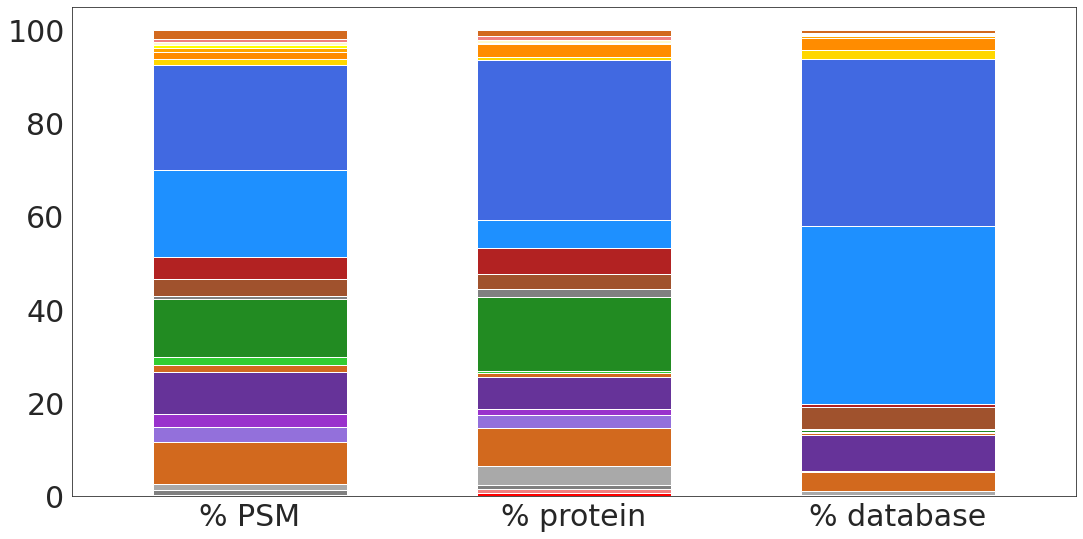

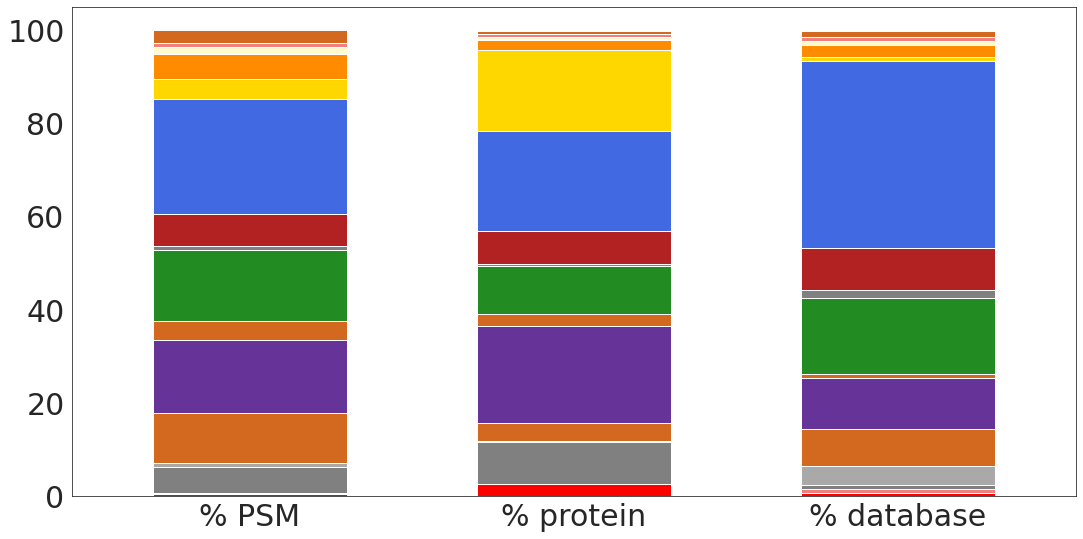

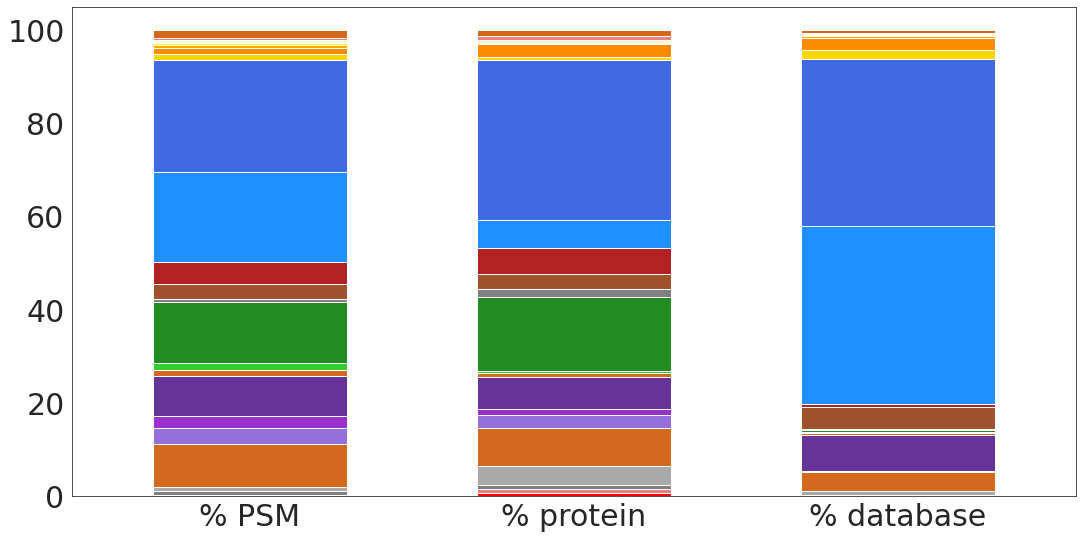

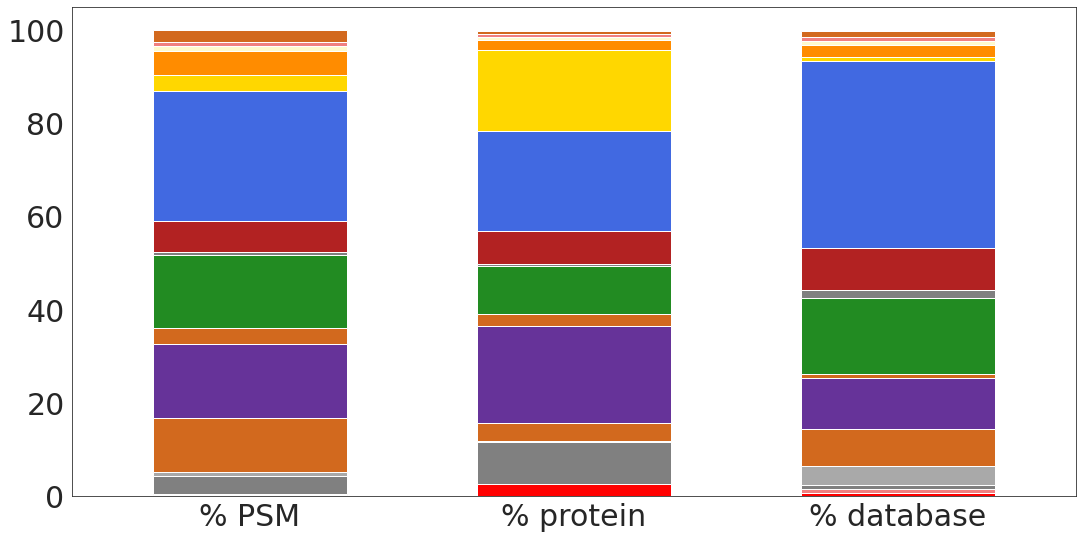

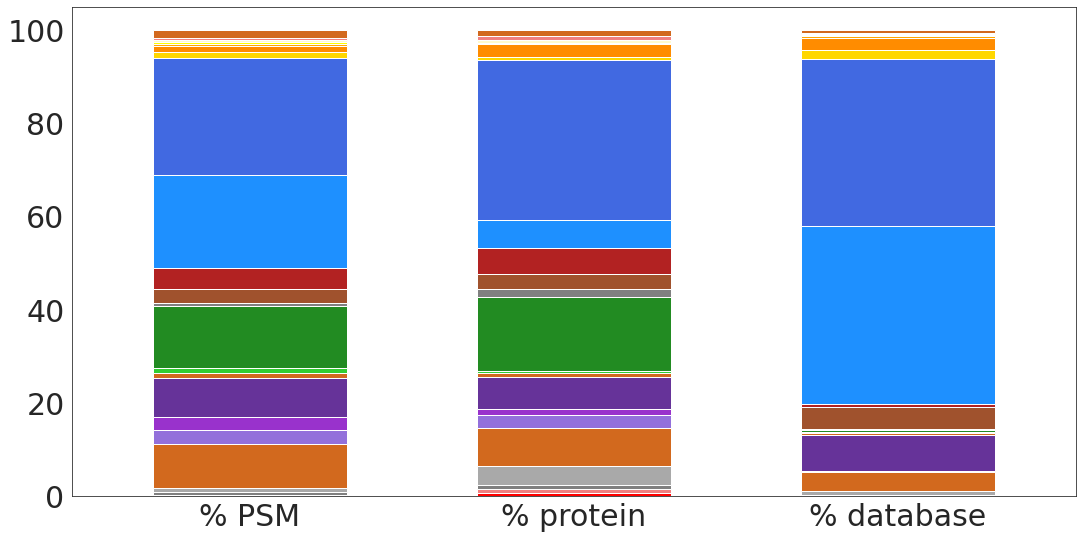

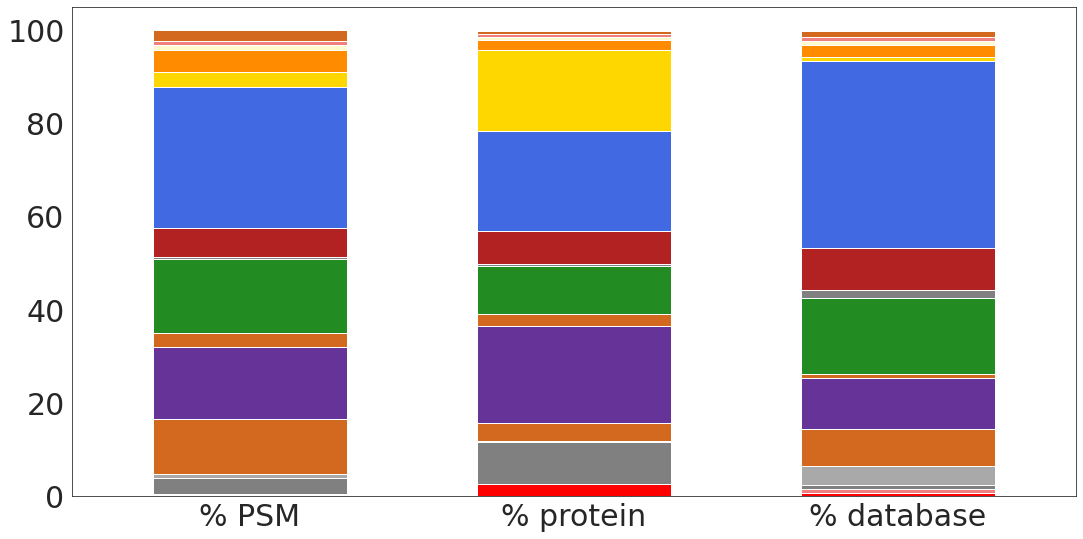

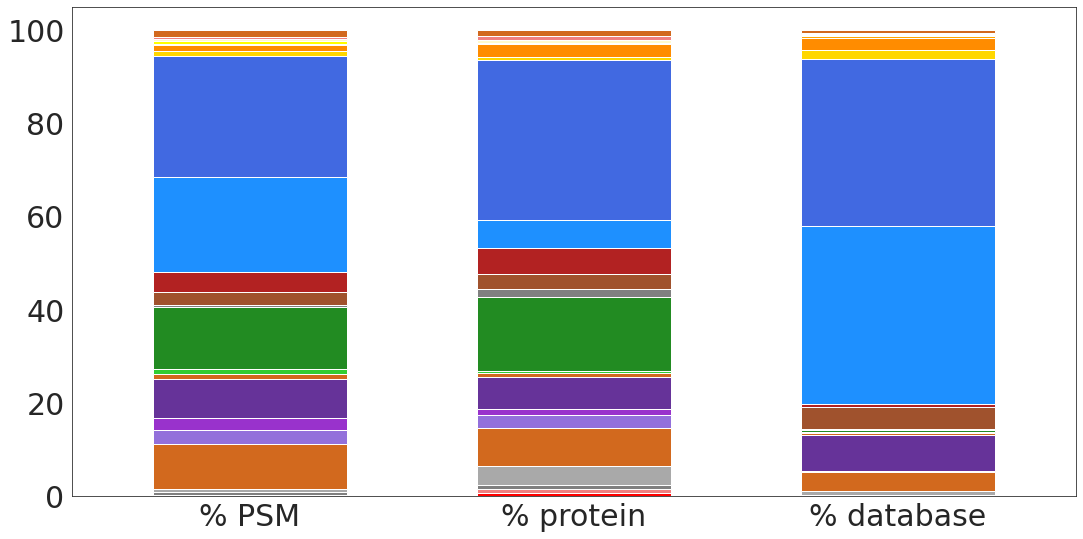

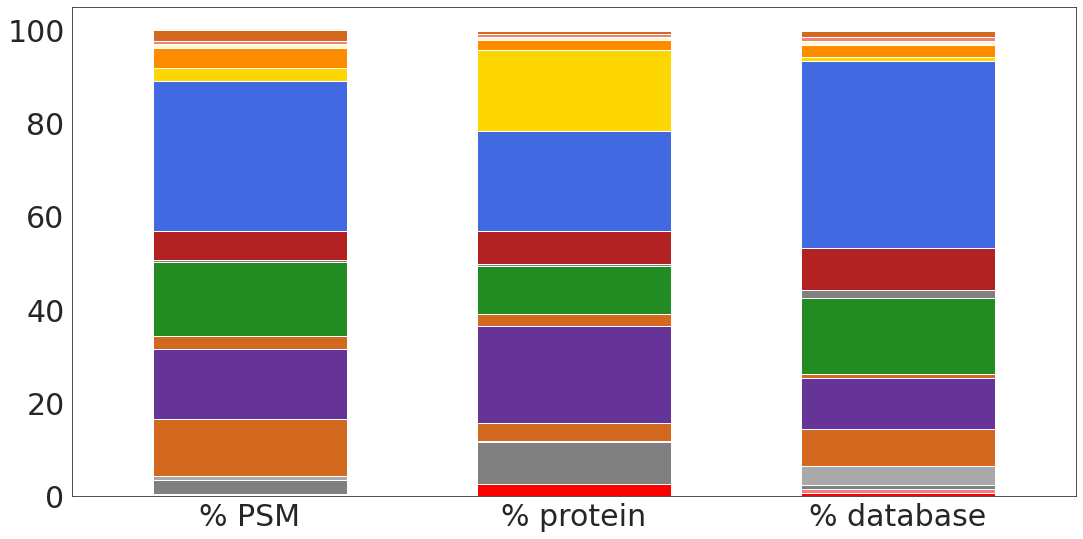

In [159]:
#PLOT

outputpath = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/taxon_specific_identification/new/"
fdr = 0.05

for number_hits in [1,2,3,4]:
    df_in_fdr_uniprot_species_no_one_hits = remove_all_accs_with_less_then_x_peptides(df_in_fdr_uniprot_species.copy(deep=True),  
                                                                                  'species', number_hits, acc_to_taxid_dict)
    df_in_fdr_uniprot_family_no_one_hits = remove_all_accs_with_less_then_x_peptides(df_in_fdr_uniprot_family.copy(deep=True),  
                                                                                     'family', number_hits, acc_to_taxid_dict) 
    input_files = [
    {'df': df_in_fdr_uniprot_species_no_one_hits,
     'path_ground_truth': "/home/jules/Documents/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_unidb_species.txt", 
     'level': "species"},
    {'df': df_in_fdr_uniprot_family_no_one_hits,
     'path_ground_truth': "/home/jules/Documents/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_unidb_family.txt", 
     'level': "family"}]                  
    for files in input_files:
        create_psms_per_taxID_plot(files['df'], files['path_ground_truth'], files['level'], fdr, \
                                   f"{outputpath}taxon_specific_ident_mind_{number_hits}_hits_{files['level']}.svg")

In [126]:
df_in_fdr_uniprot_species_no_one_hits = remove_all_accs_with_less_then_x_peptides(df_in_fdr_uniprot_species.copy(deep=True),  
                                                                              'species', 2, acc_to_taxid_dict)
df_in_fdr_uniprot_family_no_one_hits = remove_all_accs_with_less_then_x_peptides(df_in_fdr_uniprot_family.copy(deep=True),  
                                                                             'family', 2, acc_to_taxid_dict)        


In [ ]:
for files in input_files:
    create_psms_per_taxID_plot(files['df'], files['path_ground_truth'], files['level'], fdr, \
                                   f"{outputpath}taxon_specific_ident_mind_{number_hits-1}_hits.svg")

In [57]:
vt = ("viruses", [10754, 101570, 1985310, 329852, 1977402], [10744, 10699, 10662, 11989, 10860])
all_identified_spectra_spe, all_identified_spectra_no_one_hits_spe, all_identified_accs_spe, all_identified_accs_spe_no_one_hits, exclusive_spectra_spe, exclusive_spectra_no_one_hits_spe = \
            taxon_exclusive_spectra(df_in_fdr_uniprot_species, df_in_fdr_uniprot_species_no_one_hits, vt[1], 'species', acc_to_taxid_dict)
all_identified_spectra_fam, all_identified_spectra_no_one_hits_fam, all_identified_accs_fam, all_identified_accs_fam_no_one_hits, exclusive_spectra_fam, exclusive_spectra_no_one_hits_fam = \
    taxon_exclusive_spectra(df_in_fdr_uniprot_family, df_in_fdr_uniprot_family_no_one_hits, vt[2], 'family', acc_to_taxid_dict)
new_identified_spectra, spectra_in_species_df = spectra_identified_in_df(df_in_fdr_uniprot_species,
                                                                        df_in_fdr_uniprot_family, 
                                                                         vt[1], vt[2])
new_identified_spectra_no_one_hits, spectra_in_species_df_no_one_hits = spectra_identified_in_df(df_in_fdr_uniprot_species_no_one_hits,
                                                                        df_in_fdr_uniprot_family_no_one_hits, 
                                                                         vt[1], vt[2])
print("all_identified_spectra_fam: ", len(all_identified_spectra_fam), "\nall_identified_spectra_no_one_hits_fam: ", 
      len(all_identified_spectra_no_one_hits_fam), "\nall_identified_accs_fam: ", len(all_identified_accs_fam), 
      "\nall_identified_accs_fam_no_one_hits: ", len(all_identified_accs_fam_no_one_hits), 
      "\nspectra_in_species_df no one hits: ", len(spectra_in_species_df),
      "\nexclusive_spectra_fam: ", len(exclusive_spectra_fam), "\nexclusive_spectra_no_one_hits_fam: ", len(exclusive_spectra_no_one_hits_fam))
print(        len(exclusive_spectra_no_one_hits_spe), len(exclusive_spectra_no_one_hits_fam),
               len(new_identified_spectra), len(spectra_in_species_df),
                  len(new_identified_spectra_no_one_hits), len(spectra_in_species_df_no_one_hits))

/tmp/ipykernel_4134/4058468879.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"taxID_{level}"] = df.Protein.apply(lambda acc_list: [get_taxid_of_acc(acc, level, taxon_graph, acc_2_taxid_dict) for acc in acc_list])


all_identified_spectra_fam:  175 
all_identified_spectra_no_one_hits_fam:  70 
all_identified_accs_fam:  280 
all_identified_accs_fam_no_one_hits:  7 
spectra_in_species_df no one hits:  153 
exclusive_spectra_fam:  29 
exclusive_spectra_no_one_hits_fam:  0
0 0 174 153 70 70


In [77]:
("staphylococcus aureus", [1280]), ("bacillus subtilis", [1423])
taxon_family_b = [taxon_graph.find_level_up(1423, "family")]
taxon_family_s = [taxon_graph.find_level_up(1280, "family")]        
all_identified_spectra_spe_b, all_identified_spectra_no_one_hits_spe_b, all_identified_accs_spe_b, \
all_identified_accs_spe_no_one_hits_b, exclusive_spectra_spe_b, exclusive_spectra_no_one_hits_spe_b = \
    taxon_exclusive_spectra(df_in_fdr_uniprot_species, df_in_fdr_uniprot_species_no_one_hits, [1423], 'species', acc_to_taxid_dict)
all_identified_spectra_fam_b, all_identified_spectra_no_one_hits_fam_b, all_identified_accs_fam_b, \
all_identified_accs_fam_no_one_hits_b, exclusive_spectra_fam_b, exclusive_spectra_no_one_hits_fam_b = \
    taxon_exclusive_spectra(df_in_fdr_uniprot_family, df_in_fdr_uniprot_family_no_one_hits, taxon_family_b, 'family', acc_to_taxid_dict)
new_identified_spectra_b, spectra_in_species_df_b = spectra_identified_in_df(df_in_fdr_uniprot_species,\
                                                                         df_in_fdr_uniprot_family, [1423], taxon_family_b)

new_identified_spectra_no_one_hits_b, spectra_in_species_df_no_one_hits_b = spectra_identified_in_df(df_in_fdr_uniprot_species_no_one_hits,\
                                                                         df_in_fdr_uniprot_family_no_one_hits, [1423], taxon_family_b)

all_identified_spectra_spe_s, all_identified_spectra_no_one_hits_spe_s, all_identified_accs_spe_s, \
all_identified_accs_spe_no_one_hits_s, exclusive_spectra_spe_s, exclusive_spectra_no_one_hits_spe_s = \
    taxon_exclusive_spectra(df_in_fdr_uniprot_species, df_in_fdr_uniprot_species_no_one_hits, [1280], 'species', acc_to_taxid_dict)
all_identified_spectra_fam_s, all_identified_spectra_no_one_hits_fam_s, all_identified_accs_fam_s, \
all_identified_accs_fam_no_one_hits_s, exclusive_spectra_fam_s, exclusive_spectra_no_one_hits_fam_s = \
    taxon_exclusive_spectra(df_in_fdr_uniprot_family, df_in_fdr_uniprot_family_no_one_hits, taxon_family_s, 'family', acc_to_taxid_dict)
new_identified_spectra_s, spectra_in_species_df_s = spectra_identified_in_df(df_in_fdr_uniprot_species,\
                                                                         df_in_fdr_uniprot_family, [1280], taxon_family_s)

new_identified_spectra_no_one_hits_s, spectra_in_species_df_no_one_hits_s = spectra_identified_in_df(df_in_fdr_uniprot_species_no_one_hits,\
                                                                         df_in_fdr_uniprot_family_no_one_hits, [1280], taxon_family_s)

/tmp/ipykernel_4134/1727190670.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"taxID_{level}"] = df.Protein.apply(lambda acc_list: [get_taxid_of_acc(acc, level, taxon_graph, acc_2_taxid_dict) for acc in acc_list])


In [83]:
("staphylococcus aureus", [1280]), ("bacillus subtilis", [1423])
taxon_family_b = taxon_graph.find_level_up(1423, "family")
taxon_family_s = taxon_graph.find_level_up(1280, "family")        
all_identified_spectra_spe_bs, all_identified_spectra_no_one_hits_spe_bs, all_identified_accs_spe_bs, \
all_identified_accs_spe_no_one_hits_bs, exclusive_spectra_spe_bs, exclusive_spectra_no_one_hits_spe_bs = \
    taxon_exclusive_spectra(df_in_fdr_uniprot_species, df_in_fdr_uniprot_species_no_one_hits, [1423, 1280], 'species', acc_to_taxid_dict)
all_identified_spectra_fam_bs, all_identified_spectra_no_one_hits_fam_bs, all_identified_accs_fam_bs, \
all_identified_accs_fam_no_one_hits_bs, exclusive_spectra_fam_bs, exclusive_spectra_no_one_hits_fam_bs = \
    taxon_exclusive_spectra(df_in_fdr_uniprot_family, df_in_fdr_uniprot_family_no_one_hits, [taxon_family_b, taxon_family_s], 'family', acc_to_taxid_dict)
new_identified_spectra_bs, spectra_in_species_df_bs = spectra_identified_in_df(df_in_fdr_uniprot_species,\
                                                                         df_in_fdr_uniprot_family, [1423, 1280], [taxon_family_b, taxon_family_s])


/tmp/ipykernel_4134/1727190670.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"taxID_{level}"] = df.Protein.apply(lambda acc_list: [get_taxid_of_acc(acc, level, taxon_graph, acc_2_taxid_dict) for acc in acc_list])


In [84]:
print(len(all_identified_spectra_fam_s))
print(len(all_identified_spectra_fam_b))
print(len(all_identified_spectra_fam_bs))
print(len(all_identified_spectra_fam_b.intersection(all_identified_spectra_fam_s)))
print(len(all_identified_spectra_no_one_hits_spe_s))
print(len(all_identified_spectra_no_one_hits_spe_b))
print(len(all_identified_spectra_no_one_hits_spe_bs))
print(len(all_identified_spectra_no_one_hits_spe_s.intersection(all_identified_spectra_no_one_hits_spe_b)))


2850
2352
4315
887
656
665
1216
105


In [ ]:
display(df_in_fdr_uniprot_family[df_in_fdr_uniprot_family.Title.isin(exclusive_spectra_fam)])

In [ ]:
display(df_in_fdr_uniprot_family_no_one_hits)

101378
Start reading accession2prot database file with 8 threads.
10% read.
20% read.
30% read.
40% read.
50% read.
60% read.
70% read.
80% read.
90% read.


/tmp/ipykernel_4134/1830859167.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"taxID_{level}"] = df.Protein.apply(lambda acc_list: [get_taxid_of_acc(acc, level, taxon_graph, acc_2_taxid_dict) for acc in acc_list])
